# 3.6 softmax回归的从零开始实现

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
from IPython import display
# import sys
# sys.path.append("..") # 为了导入上层目录的d2lzh_pytorch
# import d2lzh_pytorch as d2l
# from d2l import torch as d2l

# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(torch.__version__)
print(torchvision.__version__)

2.1.0
0.16.0


## 3.6.1 获取和读取数据

In [5]:
batch_size = 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

NameError: name 'd2l' is not defined

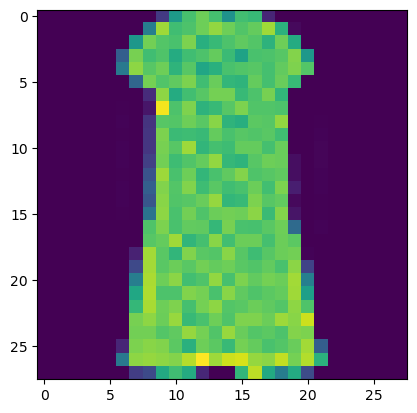

In [42]:
# 自己玩一下
it = iter(train_iter)

def draw_singe_img(image):
    fig, ax = plt.subplots()
    ax.imshow(image.reshape(28, 28).numpy())
t = next(it)
imgs, labels = t[0], t[1]
draw_singe_img(imgs[6])

## 3.6.2 初始化模型参数

In [43]:
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)
W.size(), b.size()

(torch.Size([784, 10]), torch.Size([10]))

In [44]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [45]:
X = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


## 3.6.3 实现softmax运算

In [46]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [47]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.2149, 0.1846, 0.2212, 0.1392, 0.2400],
        [0.1616, 0.1662, 0.1577, 0.2259, 0.2887]]) tensor([1.0000, 1.0000])


## 3.6.4 定义模型

In [48]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

## 3.6.5 定义损失函数

In [49]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [50]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

## 3.6.6 计算分类准确率

In [51]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [52]:
print(accuracy(y_hat, y))

0.5


In [53]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [54]:
print(evaluate_accuracy(test_iter, net))

0.085


## 3.6.7 训练模型

In [55]:
num_epochs, lr = 5, 0.1

# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.6234, train acc 0.792, test acc 0.820
epoch 2, loss 0.4891, train acc 0.833, test acc 0.821
epoch 3, loss 0.4640, train acc 0.840, test acc 0.835
epoch 4, loss 0.4509, train acc 0.846, test acc 0.838
epoch 5, loss 0.4401, train acc 0.848, test acc 0.833


## 3.6.8 预测

In [59]:
import matplotlib_inline


def show_fashion_mnist(images, labels):
    # display.set_matplotlib_formats('svg')
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

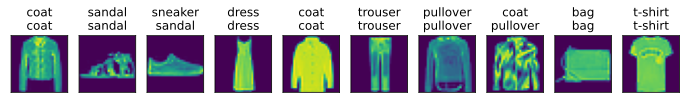

In [60]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[10:20], titles[10:20])